<a href="https://colab.research.google.com/github/erbisti/Collab/blob/main/VAE_stable%20diffusion_explicacoes_teoricas_com_imagem_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geração de Imagens com VAE Pré-Treinado (CPU)
Este notebook demonstra como usar um modelo de **Autoencoder Variacional (VAE)** já treinado, especificamente o `AutoencoderKL` utilizado no **Stable Diffusion**, para gerar imagens a partir de vetores latentes.

O modelo utilizado foi publicado pela equipe da Stability AI e é acessível através da biblioteca `diffusers`.

A execução será feita na **CPU**, para garantir compatibilidade com ambientes sem GPU.

## O que são as bibliotecas utilizadas?
- `torch` (PyTorch): Biblioteca de machine learning para criação e execução de redes neurais.
- `torchvision`: Biblioteca complementar ao PyTorch, usada para manipular imagens, carregar datasets e gerar grids de imagens.
- `diffusers`: Biblioteca da Hugging Face que oferece acesso fácil a modelos de geração de imagens como diffusion models, VAEs e outros.
- `accelerate`: Backend utilizado pela `diffusers` para configurar o ambiente de execução (GPU/CPU, paralelismo, etc).
- `matplotlib`: Biblioteca de visualização usada para exibir as imagens.

In [ ]:
!pip install diffusers accelerate torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00


In [ ]:
from diffusers import AutoencoderKL
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

## O que é um AutoencoderKL?
- É uma variante de Autoencoder Variacional usada para codificar imagens em um espaço latente de distribuição normal.
- `AutoencoderKL` é a implementação do VAE utilizado internamente pelo modelo **Stable Diffusion**.
- Ao contrário de um autoencoder clássico, ele aprende não apenas um ponto, mas uma **distribuição de vetores latentes**.
- Esse modelo foi treinado para reconstruir imagens com alta fidelidade a partir desses vetores.


In [ ]:
# Carrega o modelo VAE na CPU
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float32)
vae = vae.to("cpu")
vae.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

## Geração de imagens com vetores aleatórios no espaço latente
Criamos vetores `z` com distribuição normal padrão (ruído), e os passamos pelo decoder do VAE para gerar imagens.
O espaço latente tem dimensão `[batch, 4, 32, 32]`, ou seja, 4 canais com 32x32 cada.

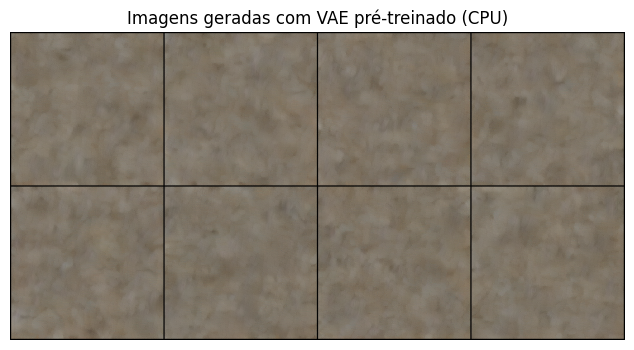

In [ ]:
batch = 8
z = torch.randn(batch, 4, 32, 32)
with torch.no_grad():
    imgs = vae.decode(z).sample
imgs = (imgs * 0.5 + 0.5).clamp(0,1)
grid = make_grid(imgs, nrow=4)
plt.figure(figsize=(8,4))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("Imagens geradas com VAE pré-treinado (CPU)")
plt.show()

Saving bonita.jpg to bonita.jpg


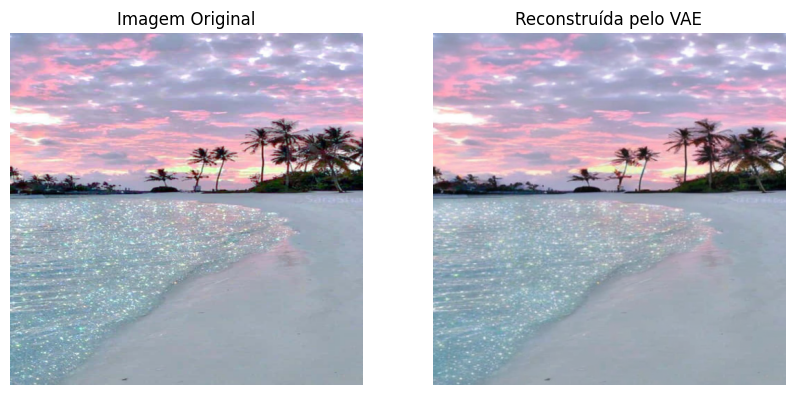

In [ ]:
from google.colab import files
uploaded = files.upload()  # Isso abrirá o seletor de arquivo

from PIL import Image
from torchvision import transforms
import torch
from diffusers import AutoencoderKL
import matplotlib.pyplot as plt

# Carrega e prepara a imagem
img = Image.open("bonita.jpg").convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    lambda x: 2.0 * x - 1.0  # Normaliza para [-1, 1]
])
img_tensor = preprocess(img).unsqueeze(0)

# Carrega modelo
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float32)
vae = vae.to("cpu")
vae.eval()

# Encode → Decode
with torch.no_grad():
    latent = vae.encode(img_tensor).latent_dist.sample()
    recon = vae.decode(latent).sample

# Visualização
recon = (recon * 0.5 + 0.5).clamp(0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.resize((512, 512)))
plt.title("Imagem Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon[0].permute(1, 2, 0))
plt.title("Reconstruída pelo VAE")
plt.axis("off")
plt.show()


## Manipulação direta do vetor latente
Aqui criamos um vetor `z` com todos os valores zerados e ativamos um ponto específico com valor alto (`3.0`).
Isso nos permite explorar como partes específicas do vetor latente afetam a imagem gerada.

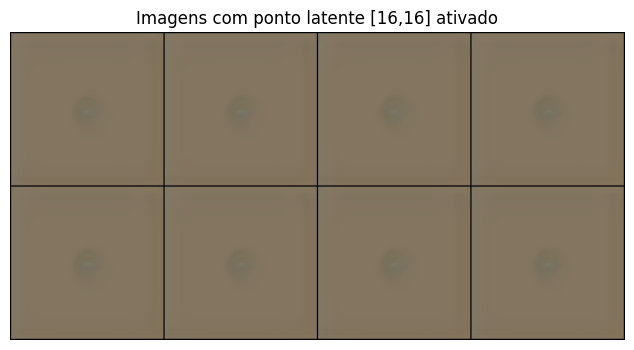

In [ ]:
z = torch.zeros(batch, 4, 32, 32)
z[:, :, 16, 16] = 3.0
with torch.no_grad():
    imgs = vae.decode(z).sample
imgs = (imgs * 0.5 + 0.5).clamp(0,1)
grid = make_grid(imgs, nrow=4)
plt.figure(figsize=(8,4))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("Imagens com ponto latente [16,16] ativado")
plt.show()

## Interpolação entre dois vetores latentes
Interpolamos entre dois vetores `z0` e `z1` com pesos crescentes, e observamos a transição visual entre eles.
Esse tipo de operação revela como o espaço latente é **suave** e permite **variações contínuas** nas imagens.

In [ ]:
z0 = torch.randn(1, 4, 32, 32)
z1 = torch.randn(1, 4, 32, 32)
steps = 8
interpolated = []
for alpha in torch.linspace(0, 1, steps):
    z_interp = (1 - alpha) * z0 + alpha * z1
    with torch.no_grad():
        img = vae.decode(z_interp).sample
        interpolated.append((img * 0.5 + 0.5).clamp(0, 1))
imgs_interp = torch.cat(interpolated, dim=0)
grid = make_grid(imgs_interp, nrow=steps)
plt.figure(figsize=(16,4))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("Interpolação no espaço latente entre dois vetores z")
plt.show()

### Diferença entre Autoencoder Puro (AE) e VAE

O objetivo de um **Autoencoder Variacional (VAE)** **não** é simplesmente reconstruir uma cópia fiel da imagem de entrada, como faz um AE tradicional.

Enquanto o **AE puro** tenta minimizar o erro de reconstrução de forma determinística, o **VAE impõe uma restrição estatística ao espaço latente**, forçando os vetores latentes `z` a seguirem uma distribuição Gaussiana padrão (`N(0,1)`).

---

#### O que isso significa na prática?

A reconstrução do VAE é sempre uma combinação de:

- Informações da imagem de entrada.
- Limitações impostas pela regularização estatística (**KL Divergence**).

---

#### Efeitos principais:

- As imagens reconstruídas por um VAE tendem a ser **mais suaves e menos detalhadas**, porque o modelo prioriza **gerar amostras plausíveis dentro da distribuição global aprendida**, ao invés de replicar exatamente os detalhes da imagem original.
- Essa suavização é um **efeito colateral esperado**, especialmente quando se usa funções de perda como **MSE** ou **BCE**.
- O **verdadeiro propósito do VAE** é organizar o espaço latente de modo que seja possível:
  - Reconstruir imagens plausíveis.
  - E também **gerar novas imagens realistas** a partir de vetores `z` amostrados aleatoriamente.

---

#### Resumo:

| | AE Puro | VAE |
|---|---|---|
| **Reconstrução** | Fiel aos pixels de entrada | Aproximada e estatisticamente plausível |
| **Espaço latente** | Sem restrição | Forçado a seguir distribuição Gaussiana |
| **Capacidade de geração** | Limitada | Alta |
| **Resultado visual** | Mais nítido | Mais suave |

---
